In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score, accuracy_score, precision_score, recall_score, f1_score, top_k_accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from imblearn.metrics import geometric_mean_score
import json
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
import matplotlib.transforms as mtrans
from matplotlib.lines import Line2D
import warnings
warnings.simplefilter("ignore")

In [2]:
with open('DDR-dataset/DR_grading/Predictions/resnet_preds.json') as f:
    resnet_preds = json.load(f)

with open('DDR-dataset/DR_grading/Predictions/inception_preds.json') as f:
    inception_preds = json.load(f)  

with open('DDR-dataset/DR_grading/Predictions/eff_b0_preds.json') as f:
    eff_b0_preds = json.load(f)

with open('DDR-dataset/DR_grading/Predictions/eff_b4_preds.json') as f:
    eff_b4_preds = json.load(f)

with open('DDR-dataset/DR_grading/Predictions/all_labels.json') as f:
    all_labels = json.load(f)


with open('DDR-dataset/DR_grading/Predictions/resnet_pred_proba.json') as f:
    resnet_pred_proba = json.load(f)

with open('DDR-dataset/DR_grading/Predictions/inception_pred_proba.json') as f:
    inception_pred_proba = json.load(f)

with open('DDR-dataset/DR_grading/Predictions/eff_b0_pred_proba.json') as f:
    eff_b0_pred_proba = json.load(f)

with open('DDR-dataset/DR_grading/Predictions/eff_b4_pred_proba.json') as f:
    eff_b4_pred_proba = json.load(f)

In [76]:
def top_k_accuracy(y_true, y_proba, k=1):
    return np.mean(np.array([y_true[i] in np.argsort(y_proba[i])[-k:] for i in range(len(y_true))]))


def weighted_specificity(y_true, y_pred):
    total_specificity = 0
    total_instances = 0
    cm = confusion_matrix(y_true, y_pred)
    n_classes = cm.shape[0]

    # Calculate the specificity for each class
    for i in range(n_classes):
        tn = cm[i, i]
        fp = cm[i, :].sum() - cm[i, i]
        fn = cm[:, i].sum() - cm[i, i]
        tp = cm.sum() - tn - fp - fn

        specificity = tn / (tn + fp)

        num_instances = tn + fp

        total_specificity += specificity * num_instances

        total_instances += num_instances

    weighted_avg_specificity = total_specificity / total_instances

    return weighted_avg_specificity

results = pd.DataFrame(columns=['Model', 'Accuracy', 'Top-2 Accuracy', 'Top-3 Accuracy', 'Sensitivity', 'Specificity', 'F1 Score', 'Error Rate', 'Precision', 'Recall', 'Kappa', 'Geometric Mean'])

model_names = ['Resnet-50', 'Inception-v3', 'Efficientnet-B0', 'Efficientnet-B4']  
models_preds_proba = {
    'Resnet-50': resnet_pred_proba,
    'Inception-v3': inception_pred_proba,
    'Efficientnet-B0': eff_b0_pred_proba,
    'Efficientnet-B4': eff_b4_pred_proba
}

for y_pred, model_name in zip([resnet_preds, inception_preds, eff_b0_preds, eff_b4_preds], model_names):
    pred_proba = models_preds_proba[model_name]

    # Calculate metrics
    accuracy = accuracy_score(all_labels, y_pred)
    precision = precision_score(all_labels, y_pred, average='weighted')
    recall = recall_score(all_labels, y_pred, average='weighted')
    f1 = f1_score(all_labels, y_pred, average='weighted')
    kappa = cohen_kappa_score(all_labels, y_pred)
    gmean = geometric_mean_score(all_labels, y_pred, average='weighted')
    specificity = weighted_specificity(all_labels, y_pred)

    # Calculate specificity and error rate
    # tn, fp, fn, tp = confusion_matrix(all_labels, y_pred).ravel()
    # specificity = tn / (tn+fp)
    error_rate = 1 - accuracy
    top_2_acc = top_k_accuracy(all_labels, pred_proba, 2)
    top_3_acc = top_k_accuracy(all_labels, pred_proba, 3)

    # Add the metrics to the results DataFrame
    new_row = pd.DataFrame({
    'Model': [model_name],
    'Accuracy': [accuracy],
    'Top-2 Accuracy': [top_2_acc],
    'Top-3 Accuracy': [top_3_acc],
    'Sensitivity': [recall],
    'Specificity': [specificity], 
    'F1 Score': [f1],
    'Error Rate': [error_rate],
    'Precision': [precision],
    'Recall': [recall],
    'Kappa': [kappa],
    'Geometric Mean': [gmean]
})

    results = pd.concat([results, new_row], ignore_index=True)

# Transpose the DataFrame
results = results.set_index('Model').T

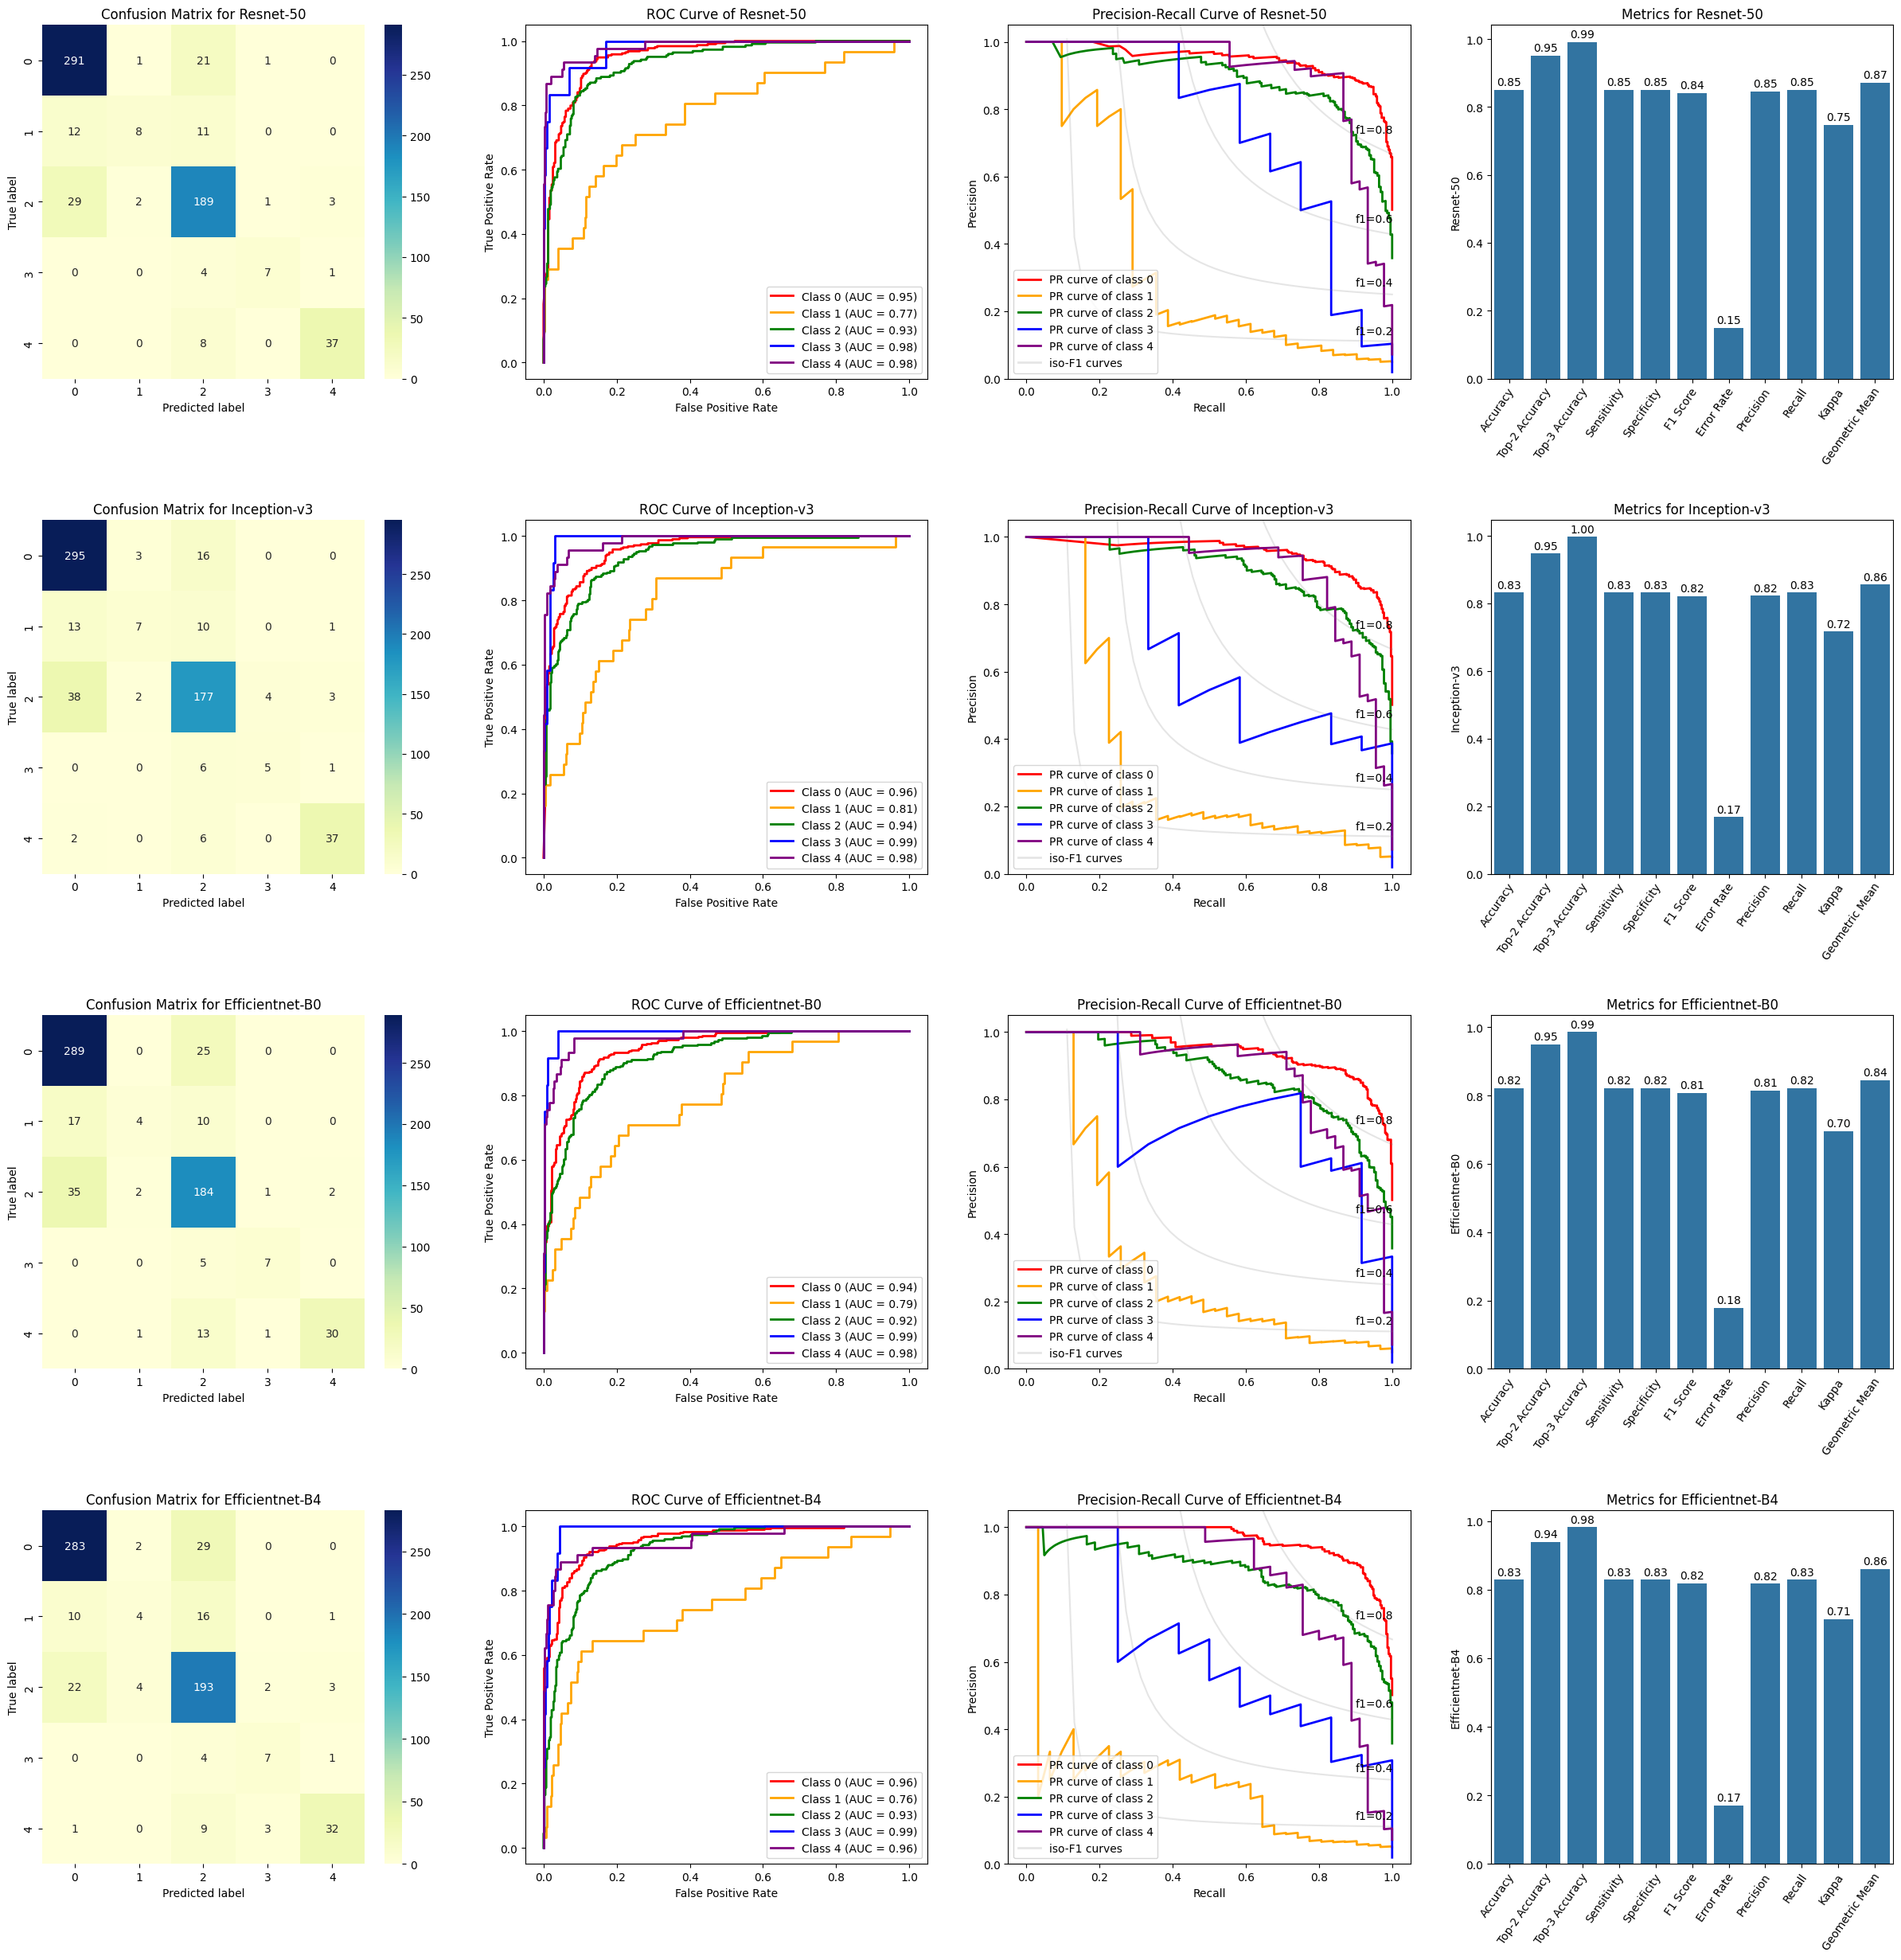

In [77]:
n_rows = 4
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 30), )

# Adjust the space between rows
plt.subplots_adjust(hspace=0.4)

# Binarize the output
y = label_binarize(all_labels, classes=[0, 1, 2, 3, 4]) 
n_classes = y.shape[1]

# CONFUSION MATRIX
for ax, y_pred, model_name in zip(axes[:,0], [resnet_preds, inception_preds, eff_b0_preds, eff_b4_preds], model_names):
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, y_pred)
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', ax=ax)
    ax.set_title('Confusion Matrix for ' + model_name)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

# ROC CURVE
for ax, y_pred, model_name in zip(axes[:,1], [resnet_preds, inception_preds, eff_b0_preds, eff_b4_preds], model_names):
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes):
        pred_proba = np.array(models_preds_proba[model_name])
        fpr[i], tpr[i], _ = roc_curve(y[:, i], pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    colors = cycle(['red', 'orange', 'green', 'blue', 'purple'])
    for i, color in zip(range(n_classes), colors):
        ax.plot(fpr[i], tpr[i], color=color, lw=2, label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve of {model_name}')
    ax.legend(loc="lower right")


# PRECISION-RECALL CURVE
for ax, y_pred, model_name in zip(axes[:,2], [resnet_preds, inception_preds, eff_b0_preds, eff_b4_preds], model_names):
    precision, recall, prcurve = dict(), dict(), dict()
    for i in range(n_classes):
        pred_proba = np.array(models_preds_proba[model_name])
        precision[i], recall[i], _ = precision_recall_curve(y[:, i], pred_proba[:, i])
        prcurve[i] = average_precision_score(y[:, i], pred_proba[:, i])

    colors = cycle(['red', 'orange', 'green', 'blue', 'purple'])
    for i, color in zip(range(n_classes), colors):
        ax.plot(recall[i], precision[i], color=color, lw=2, label=f'PR curve of class {i}')
        
    # Add iso-F1 curves
    f_scores = np.linspace(0.2, 0.8, num=4)
    for f_score in f_scores:
        w = np.linspace(0.01, 1)
        z = f_score * w / (2 * w - f_score)
        ax.plot(w[z >= 0], z[z >= 0], color='gray', alpha=0.2)
        ax.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, z[45] + 0.02))

    # Create a Line2D object for the iso-F1 curves
    iso_f1_line = Line2D([0], [0], color='gray', alpha=0.2, lw=2, label='iso-F1 curves')
    # Get the existing legend
    handles, labels = ax.get_legend_handles_labels()
    # Add the iso-F1 curves to the legend
    handles.append(iso_f1_line)
    ax.legend(handles=handles, loc="lower left")

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall Curve of {model_name}')
    # ax.legend(loc="lower left")
    ax.set_ylim([0.0, 1.05])


# METRICS
for ax, model_name in zip(axes[:,3], model_names):
    barplot = sns.barplot(data=results[model_name], ax=ax)
    ax.set_title(f'Metrics for {model_name}')
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=55, horizontalalignment='right')

    # Shift x-tick labels to the right
    xticklabels = ax.get_xticklabels()
    trans = mtrans.Affine2D().translate(0.2, -0.02)  # adjust the value as needed
    for label in xticklabels:
        label.set_transform(trans + ax.transData)
    ax.set_xticklabels(xticklabels, rotation=55, horizontalalignment='right')

    # Add the value on top of each bar
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.2f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', xytext = (0, 7), textcoords = 'offset points')

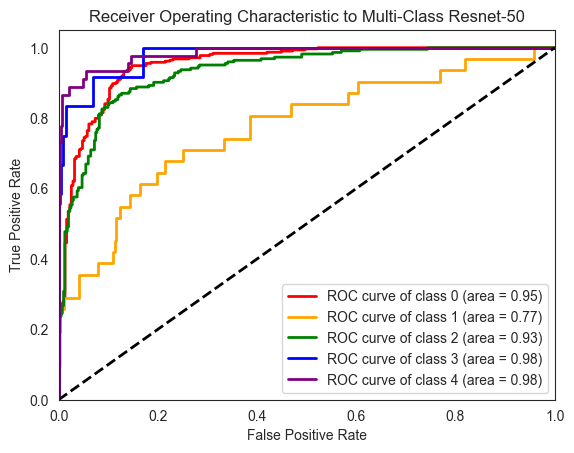

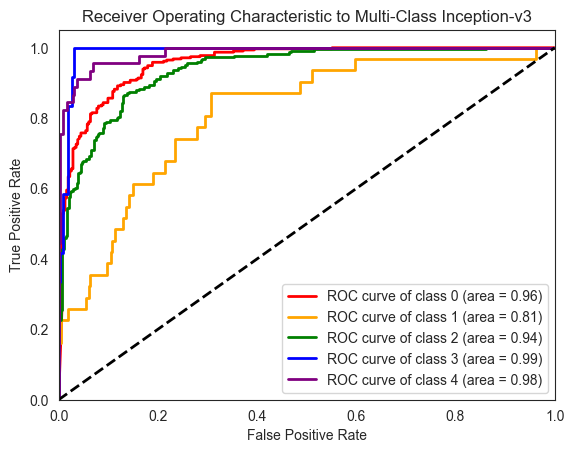

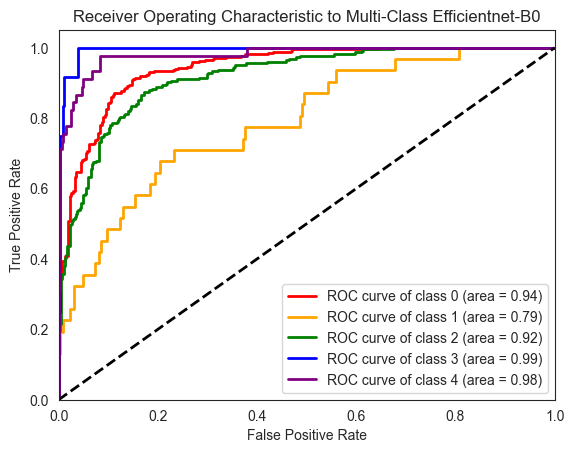

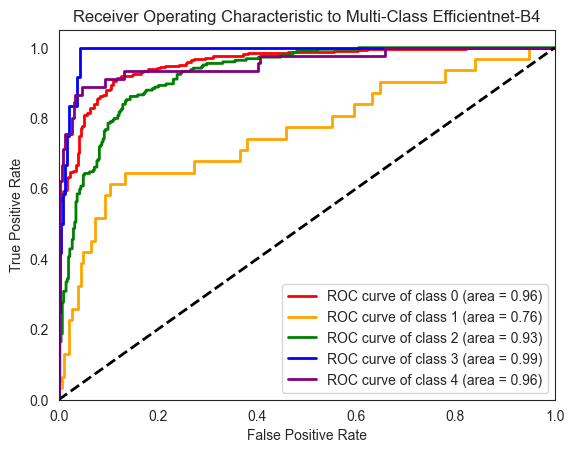

In [137]:
# Binarize the output
y = label_binarize(all_labels, classes=[0, 1, 2, 3, 4]) 
n_classes = y.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for y_pred, model_name in zip([resnet_preds, inception_preds, eff_b0_preds, eff_b4_preds], model_names):
    for i in range(n_classes):
        pred_proba = np.array(models_preds_proba[model_name])
        fpr[i], tpr[i], _ = roc_curve(y[:, i], pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure()

    colors = cycle(['red', 'orange', 'green', 'blue', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic to Multi-Class {model_name}')
    plt.legend(loc="lower right")
    plt.show()

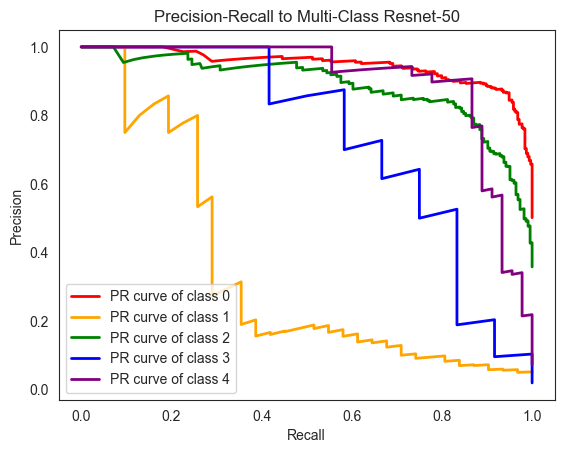

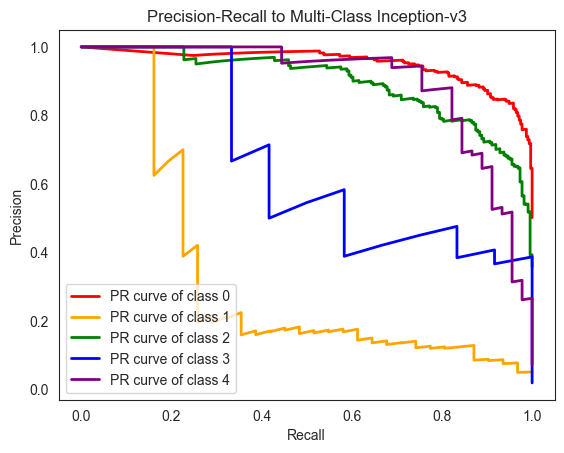

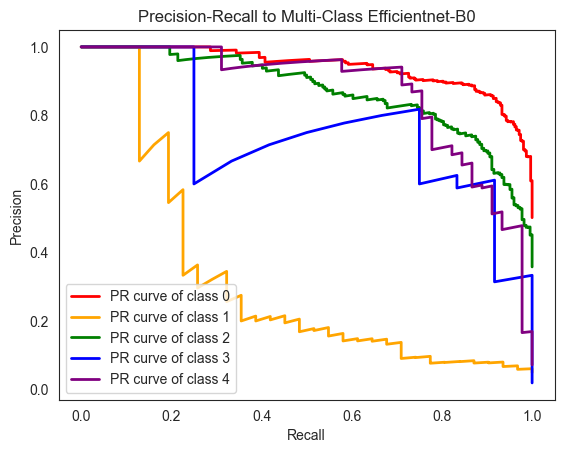

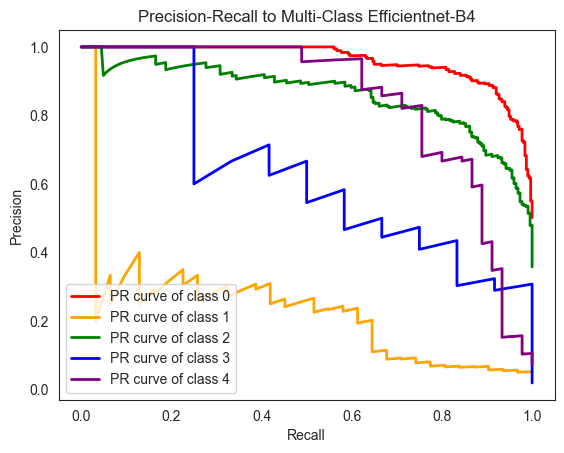

In [138]:


# Binarize the output
y = label_binarize(all_labels, classes=[0, 1, 2, 3, 4]) 
n_classes = y.shape[1]

# Compute ROC curve and ROC area for each class
precision = dict()
recall = dict()
prcurve = dict()

for y_pred, model_name in zip([resnet_preds, inception_preds, eff_b0_preds, eff_b4_preds], model_names):
    for i in range(n_classes):
        pred_proba = np.array(models_preds_proba[model_name])
        precision[i], recall[i], _ = precision_recall_curve(y[:, i], pred_proba[:, i])
        prcurve[i] = average_precision_score(y[:, i], pred_proba[:, i])


    # Plot all ROC curves
    plt.figure()

    colors = cycle(['red', 'orange', 'green', 'blue', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                label=f'PR curve of class {i}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall to Multi-Class {model_name}')
    plt.legend(loc="lower left")
    plt.show()
    

  

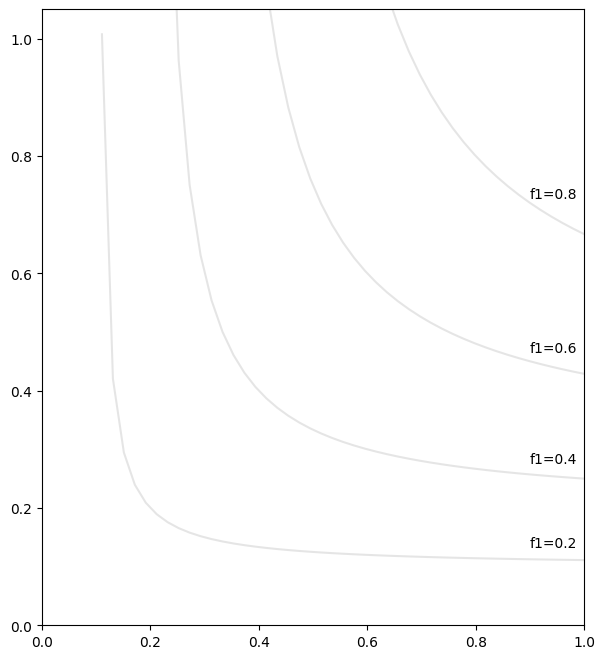

In [59]:


plt.figure(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')

# fig = plt.gcf()
# fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))

plt.show()

In [150]:
results

Model,Resnet-50,Inception-v3,Efficientnet-B0,Efficientnet-B4
Accuracy,0.849840,0.832268,0.821086,0.829073
Top-2 Accuracy,0.950479,0.947284,0.948882,0.939297
Top-3 Accuracy,0.992013,0.996805,0.985623,0.982428
Sensitivity,0.849840,0.832268,0.821086,0.829073
F1 Score,0.841374,0.821982,0.807491,0.818373
Error Rate,0.150160,0.167732,0.178914,0.170927
Precision,0.845704,0.822652,0.813514,0.817519
Recall,0.849840,0.832268,0.821086,0.829073
Kappa,0.747604,0.716771,0.695098,0.714130
Geometric Mean,0.871695,0.855708,0.844540,0.860947
